In [377]:
import re
import PIL
import copy
import kaggle
from zipfile import ZipFile

import numpy as np
import pandas as pd

from scipy import stats
from patsy import dmatrices
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from kaggle.api.kaggle_api_extended import KaggleApi

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", None)
%matplotlib inline

In [378]:
api = KaggleApi()
api.authenticate()
api.dataset_download_file('brenda89/fifa-world-cup-2022', 'international_matches.csv', path=r'C:\Users\viniciushc\Git_Vinicius\fifa_2022\data')

False

In [379]:
with ZipFile(r'C:\Users\viniciushc\Git_Vinicius\fifa_2022\data\international_matches.csv.zip', 'r') as zip_file:
    zip_file.extractall(
        r'C:\Users\viniciushc\Git_Vinicius\fifa_2022\data'
    )

# Reading Data

In [380]:
df_fifa = pd.read_csv(r'C:\Users\viniciushc\Git_Vinicius\fifa_2022\data\international_matches.csv')

In [381]:
df_fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           23921 non-null  object 
 1   home_team                      23921 non-null  object 
 2   away_team                      23921 non-null  object 
 3   home_team_continent            23921 non-null  object 
 4   away_team_continent            23921 non-null  object 
 5   home_team_fifa_rank            23921 non-null  int64  
 6   away_team_fifa_rank            23921 non-null  int64  
 7   home_team_total_fifa_points    23921 non-null  int64  
 8   away_team_total_fifa_points    23921 non-null  int64  
 9   home_team_score                23921 non-null  int64  
 10  away_team_score                23921 non-null  int64  
 11  tournament                     23921 non-null  object 
 12  city                           23921 non-null 

In [382]:
df_fifa.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,1,Friendly,Maceió,Brazil,False,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,0,FIFA World Cup qualification,Quito,Ecuador,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,0,Friendly,Conakry,Guinea,False,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [383]:
df_fifa.tail()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,1,UEFA Nations League,Chișinău,Moldova,False,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,2,UEFA Nations League,Vaduz,Liechtenstein,False,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,0,Kirin Cup,Suita,Japan,True,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,3,Kirin Cup,Suita,Japan,False,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,1,Friendly,Seoul,Korea Republic,False,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


In [384]:
df_fifa.shape

(23921, 25)

# Feature Engineering

In [385]:
df_fifa_features = df_fifa.copy()

### Spliting date feature into year and month and day

In [386]:
df_data_split = df_fifa_features['date'].apply([
    lambda x: x.split('-')[0],
    lambda x: x.split('-')[1],
    lambda x: x.split('-')[2]]
)
df_fifa_features['year'] = df_data_split.iloc[:,:1]
df_fifa_features['month'] = df_data_split.iloc[:,1:2]
df_fifa_features['day'] = df_data_split.iloc[:,2:3]

In [387]:
df_fifa_features.columns

Index(['date', 'home_team', 'away_team', 'home_team_continent',
       'away_team_continent', 'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_total_fifa_points', 'away_team_total_fifa_points',
       'home_team_score', 'away_team_score', 'tournament', 'city', 'country',
       'neutral_location', 'shoot_out', 'home_team_result',
       'home_team_goalkeeper_score', 'away_team_goalkeeper_score',
       'home_team_mean_defense_score', 'home_team_mean_offense_score',
       'home_team_mean_midfield_score', 'away_team_mean_defense_score',
       'away_team_mean_offense_score', 'away_team_mean_midfield_score', 'year',
       'month', 'day'],
      dtype='object')

### Sequence of columns

In [388]:
df_fifa_features = df_fifa_features.reindex(columns=[
       'date', 'year', 'month', 'day', 'home_team', 'away_team',
       'home_team_continent', 'away_team_continent', 'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_total_fifa_points', 'away_team_total_fifa_points', 'home_team_score', 'away_team_score',
       'tournament', 'city', 'country', 'neutral_location', 'shoot_out', 'home_team_result',
       'home_team_goalkeeper_score', 'away_team_goalkeeper_score', 'home_team_mean_defense_score',
       'away_team_mean_defense_score', 'home_team_mean_midfield_score', 'away_team_mean_midfield_score',
       'home_team_mean_offense_score', 'away_team_mean_offense_score', 
])

In [389]:
# Count of dtypes
df_fifa_features.dtypes.value_counts()

object     13
float64     8
int64       6
bool        1
dtype: int64

### Every categorical data to lower case

In [390]:
df_fifa_features = df_fifa_features.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

In [391]:
df_fifa_features.head()

,date,year,month,day,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,away_team_mean_defense_score,home_team_mean_midfield_score,away_team_mean_midfield_score,home_team_mean_offense_score,away_team_mean_offense_score
0,1993-08-08,1993,08,08,bolivia,uruguay,south america,south america,59,22,0,0,3,1,fifa world cup qualification,la paz,bolivia,False,no,win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,1993,08,08,brazil,mexico,south america,north america,8,14,0,0,1,1,friendly,maceió,brazil,False,no,draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,1993,08,08,ecuador,venezuela,south america,south america,35,94,0,0,5,0,fifa world cup qualification,quito,ecuador,False,no,win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,1993,08,08,guinea,sierra leone,africa,africa,65,86,0,0,1,0,friendly,conakry,guinea,False,no,win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,1993,08,08,paraguay,argentina,south america,south america,67,5,0,0,1,3,fifa world cup qualification,asunción,paraguay,False,no,lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [392]:
(df_fifa_features
    .isnull()
    .sum() / df_fifa.shape[0] * 100)

date                              0.000000
year                              0.000000
month                             0.000000
day                               0.000000
home_team                         0.000000
                                   ...    
away_team_mean_defense_score     68.379248
home_team_mean_midfield_score    65.879353
away_team_mean_midfield_score    66.644371
home_team_mean_offense_score     64.424564
away_team_mean_offense_score     65.252289
Length: 28, dtype: float64

In [393]:
df_fifa_features['home_team_goalkeeper_score'].describe()

count    8379.000000
mean       74.963838
std         8.212242
min        47.000000
25%        70.000000
50%        75.000000
75%        81.000000
max        97.000000
Name: home_team_goalkeeper_score, dtype: float64

In [394]:
df_fifa_features = df_fifa_features.fillna(0)

# Exploratory Data Analysis

In [395]:
df_fifa_eda = df_fifa_features.copy()

In [396]:
# A small sample
df_fifa_eda.sample(n = 5, random_state = int(np.cbrt(74088)))

,date,year,month,day,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,away_team_mean_defense_score,home_team_mean_midfield_score,away_team_mean_midfield_score,home_team_mean_offense_score,away_team_mean_offense_score
2476,1997-06-29,1997,06,29,bolivia,brazil,south america,south america,34,1,0,0,1,3,copa américa,la paz,bolivia,False,no,lose,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8225,2004-08-18,2004,08,18,haiti,brazil,north america,south america,95,1,0,0,0,6,friendly,port-au-prince,haiti,False,no,lose,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20053,2017-12-16,2017,12,16,china pr,korea dpr,asia,asia,60,114,560,282,1,1,eaff championship,chōfu,japan,True,no,draw,74.0,0.0,70.8,0.0,72.2,0.0,71.7,67.7
21512,2019-09-08,2019,09,08,lesotho,ethiopia,africa,africa,144,150,1072,1049,1,1,fifa world cup qualification,maseru,lesotho,False,no,draw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4104,1999-12-19,1999,12,19,dominica,st. lucia,north america,north america,147,148,0,0,2,1,friendly,roseau,dominica,False,no,win,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### How many goals was scored in each year?

In [397]:
df_fifa_eda[['year', 'home_team_score']].groupby('year').count().T

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
home_team_score,171,494,564,781,797,636,670,993,953,701,851,1016,741,763,910,1034,836,790,1022,927,942,788,938,867,885,830,1075,298,1077,571


### How many games occurred in each year?

In [398]:
x_years = df_fifa_eda[['year', 'home_team_score']].groupby('year').count().iloc[:, 1:].index
y_goals = df_fifa_eda[['year', 'home_team_score']].groupby('year').sum()

x_years_away = df_fifa_eda[['year', 'away_team_score']].groupby('year').count().iloc[:, 1:].index
y_goals_away = df_fifa_eda[['year', 'away_team_score']].groupby('year').sum()

y_games = df_fifa_eda[['year', 'month']].groupby(by='year').count()

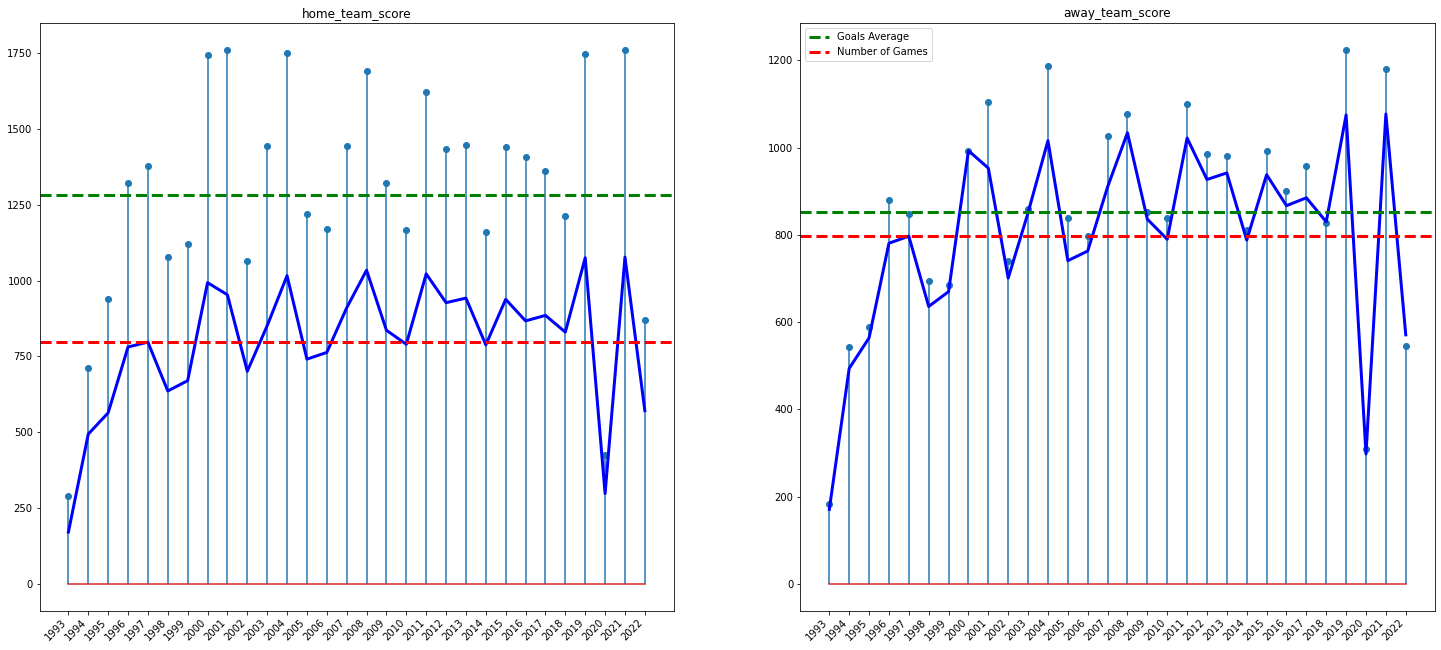

In [399]:
fig, ax = plt.subplots(1, 2, figsize=(25, 12))
ax[0].stem(x_years, np.array(y_goals))
ax[0].plot(x_years, np.array(y_games), color='blue', linewidth=3)
ax[0].set_title('home_team_score')

ax[0].axhline(y=np.mean(np.array(y_goals)), color='green', linestyle='--', linewidth=3, label='Goals Average')
ax[0].axhline(y=np.mean(np.array(y_games)), color='red', linestyle='--', linewidth=3, label='Number of Games')

ax[1].stem(x_years_away, np.array(y_goals_away))
ax[1].plot(x_years_away, np.array(y_games), color='blue', linewidth=3)
ax[1].set_title('away_team_score')

ax[1].axhline(y=np.mean(np.array(y_goals_away)), color='green', linestyle='--', linewidth=3, label='Goals Average')
ax[1].axhline(y=np.mean(np.array(y_games)), color='red', linestyle='--', linewidth=3, label='Number of Games')

# plt.xticks(rotation=45)
fig.autofmt_xdate(rotation=45)
plt.legend()
plt.show()

It is normal that in world cup years the mean rate of goals is lower than the qualification or friendly games for another years.

In [400]:
print(f"""Total teams {(df_fifa_eda['home_team']
        .unique()
        .shape)[0]}""")

Total teams 211


In [401]:
(df_fifa_eda[['year', 'home_team_score', 'away_team_score', 'home_team_continent']]
    .groupby(['year', 'home_team_continent']).agg(['min', 'max', 'mean', 'median'])
    .reset_index())

year home_team_continent home_team_score                       \
                                          min max      mean median   
0    1993              africa               0   4  1.636364    1.0   
1    1993                asia               0   4  1.730769    1.0   
2    1993              europe               0   5  1.413793    1.0   
3    1993       north america               0   8  2.000000    1.0   
4    1993             oceania               1   3  2.000000    2.0   
..    ...                 ...             ...  ..       ...    ...   
174  2022                asia               0   7  1.690265    2.0   
175  2022              europe               0   9  1.407186    1.0   
176  2022       north america               0   6  1.590361    1.0   
177  2022             oceania               0   7  1.647059    1.0   
178  2022       south america               0   9  2.024390    1.0   

    away_team_score                       
                min max      mean median  
0                 0   4  0.613636    0.0  
1                 0   3  1.346154    1.5  
2                 0   7  1.500000    1.0  
3                 0   3  0.714286    0.5  
4                 0   1  0.666667    1.0  
..              ...  ..       ...    ...  
174               0   6  0.840708    1.0  
175               0   6  1.053892    1.0  
176               0   5  1.012048    1.0  
177               0   5  1.235294    1.0  
178               0   6  0.853659    1.0  

[179 rows x 10 columns]

In [402]:
pd.set_option("display.max_rows", 10)

### Fun Facts

The Australia team scored 31 goals against the Amrican Samoa in a qualifying match.

In [403]:
df_fifa_eda[df_fifa_eda['home_team_score'] == df_fifa_eda['home_team_score'].max()]

,date,year,month,day,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,away_team_mean_defense_score,home_team_mean_midfield_score,away_team_mean_midfield_score,home_team_mean_offense_score,away_team_mean_offense_score
5410,2001-04-11,2001,04,11,australia,american samoa,oceania,oceania,77,203,0,0,31,0,fifa world cup qualification,coffs harbour,australia,False,no,win,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [404]:
df_fifa_eda[df_fifa_eda['away_team_score'] == df_fifa_eda['away_team_score'].max()]

,date,year,month,day,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,away_team_mean_defense_score,home_team_mean_midfield_score,away_team_mean_midfield_score,home_team_mean_offense_score,away_team_mean_offense_score
8740,2005-03-11,2005,03,11,guam,korea dpr,asia,asia,205,95,0,0,0,21,eaff championship,taipei,chinese taipei,True,no,lose,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


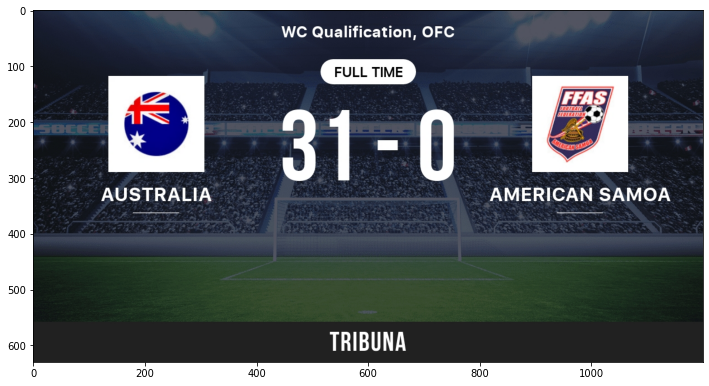

In [405]:
img = PIL.Image.open(r"C:\Users\viniciushc\Git_Vinicius\fifa_2022\data\images\austxsamoa.jpeg")
plt.figure(figsize=(12, 8))
plt.imshow(img)

c:\Users\viniciushc\Anaconda3\envs\house_prices\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\viniciushc\Anaconda3\envs\house_prices\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


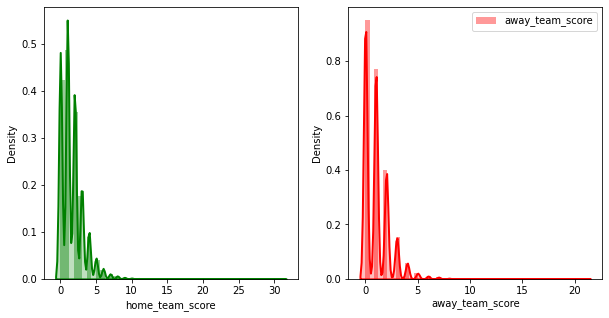

In [406]:
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)

sns.distplot(df_fifa_eda['home_team_score'], hist=True, kde=True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "home_team_score", color ="green", ax = ax[0])
  
sns.distplot(df_fifa_eda['away_team_score'], hist = True, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "away_team_score", color ="red", ax = ax[1])

plt.legend(loc="upper right")

fig.set_figheight(5)
fig.set_figwidth(10)  

In [407]:
df_fifa_eda['away_team_score'].sum(), df_fifa_eda['home_team_score'].sum()

(25554, 38494)

### Relative Frequency of Total Goals Scored by Teams of Each Continent

In [408]:
(df_fifa_eda[['home_team_continent', 'home_team_score']]
    .groupby('home_team_continent')
    .sum() / df_fifa_eda['home_team_score'].sum() * 100).sort_values('home_team_score', ascending=False).round(2)

,home_team_score
home_team_continent,
europe,30.39
asia,23.50
africa,22.25
north america,12.10
south america,8.69
oceania,3.07


In [433]:
goals_by_home_team_continent = (df_fifa_eda[['home_team_continent', 'home_team_score']]
            .groupby('home_team_continent')
            .sum()).sort_values(by='home_team_score', ascending=False)

#############################################################################

goals_by_away_team_continent = (df_fifa_eda[['away_team_continent', 'away_team_score']]
            .groupby('away_team_continent')
            .sum()).sort_values(by='away_team_score', ascending=False)

In [434]:
x_cont_ht = [continent for continent in goals_by_home_team_continent.index]
y_cont_ht = [goals[0] for goals in goals_by_home_team_continent.values]

#############################################################################

x_cont_at = [continent for continent in goals_by_away_team_continent.index]
y_cont_at = [goals[0] for goals in goals_by_away_team_continent.values]

In [411]:
df_fifa_eda.groupby('home_team_continent')['home_team'].nunique().sort_values(ascending=False)

home_team_continent
africa           56
europe           55
asia             44
north america    32
south america    13
oceania          11
Name: home_team, dtype: int64

In [413]:
(df_fifa_eda[['home_team_continent', 'home_team']]
            .groupby('home_team_continent')
            .count()).sort_values(by='home_team', ascending=False)

,home_team
home_team_continent,
europe,7593
africa,5885
asia,5302
north america,2772
south america,1839
oceania,530


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


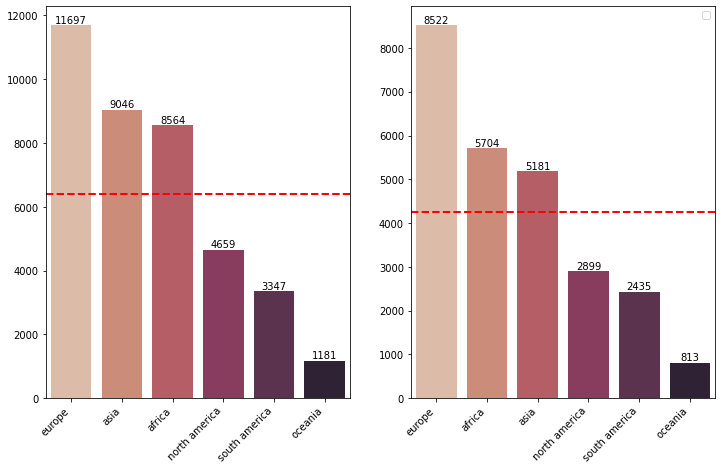

In [439]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
# creating axes to draw plots
sns.barplot(x=x_cont_ht, y=y_cont_ht, palette='rocket_r', saturation=0.5, ax=ax[0])
ax[0].axhline(y=np.mean(np.array(y_cont_ht)), color='red', linestyle='--', linewidth=2)
ax[0].bar_label(ax[0].containers[-1], label_type='edge') # fmt='Total:\n%.2f'

sns.barplot(x=x_cont_at, y=y_cont_at, palette='rocket_r', saturation=0.5, ax=ax[1])
ax[1].axhline(y=np.mean(np.array(y_cont_at)), color='red', linestyle='--', linewidth=2)
ax[1].bar_label(ax[1].containers[-1], label_type='edge') # fmt='Total:\n%.2f'

fig.autofmt_xdate(rotation=45)
plt.legend()
plt.show()

In [239]:
df_fifa_eda[(df_fifa_eda['year'] == '2014') & (df_fifa_eda['away_team_score'] >= 7)]

,date,year,month,day,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,away_team_mean_defense_score,home_team_mean_midfield_score,away_team_mean_midfield_score,home_team_mean_offense_score,away_team_mean_offense_score
16931,2014-07-08,2014,07,08,brazil,germany,south america,europe,3,2,1242,1299,1,7,fifa world cup,belo horizonte,brazil,False,no,lose,82.0,87.0,84.8,84.5,83.2,86.0,84.0,84.7
17182,2014-10-14,2014,10,14,hong kong,argentina,asia,south america,164,2,101,1630,0,7,friendly,so kon po,hong kong,False,no,lose,0.0,79.0,0.0,81.2,0.0,82.8,0.0,88.0


In [251]:
df_fifa_eda[(df_fifa_eda['year'] == '2014')]

,date,year,month,day,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,away_team_mean_defense_score,home_team_mean_midfield_score,away_team_mean_midfield_score,home_team_mean_offense_score,away_team_mean_offense_score
16592,2014-01-01,2014,01,01,kuwait,jordan,asia,asia,105,65,314,535,1,2,waff championship,doha,qatar,True,no,lose,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16593,2014-01-04,2014,01,04,bahrain,jordan,asia,asia,110,65,291,535,0,1,waff championship,doha,qatar,True,no,lose,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16594,2014-01-04,2014,01,04,namibia,ghana,africa,africa,125,24,237,848,0,1,friendly,windhoek,namibia,False,no,lose,0.0,71.0,0.0,70.5,0.0,78.5,0.0,72.7
16595,2014-01-04,2014,01,04,nigeria,ethiopia,africa,africa,37,93,710,374,2,1,friendly,abuja,nigeria,False,no,win,79.0,0.0,70.8,0.0,76.2,0.0,74.7,0.0
16596,2014-01-04,2014,01,04,qatar,kuwait,asia,asia,103,105,324,314,3,0,waff championship,doha,qatar,False,no,win,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2014-12-27,2014,12,27,qatar,estonia,asia,europe,95,84,342,390,3,0,friendly,doha,qatar,False,no,win,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0
17376,2014-12-28,2014,12,28,uzbekistan,iraq,asia,asia,74,103,454,320,0,0,friendly,sharjah,united arab emirates,True,no,draw,0.0,0.0,0.0,0.0,0.0,63.2,0.0,0.0
17377,2014-12-30,2014,12,30,bahrain,saudi arabia,asia,asia,122,102,249,323,4,1,friendly,south geelong,australia,True,no,win,0.0,70.0,0.0,69.2,0.0,72.8,0.0,73.3
17378,2014-12-30,2014,12,30,united arab emirates,jordan,asia,asia,81,81,393,393,1,0,friendly,robina,australia,True,no,win,0.0,0.0,0.0,59.0,0.0,63.5,0.0,0.0


In [253]:
df_fifa_eda[df_fifa_eda['home_team'] == 'brazil']

,date,year,month,day,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,city,country,neutral_location,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,away_team_mean_defense_score,home_team_mean_midfield_score,away_team_mean_midfield_score,home_team_mean_offense_score,away_team_mean_offense_score
1,1993-08-08,1993,08,08,brazil,mexico,south america,north america,8,14,0,0,1,1,friendly,maceió,brazil,False,no,draw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1993-08-22,1993,08,22,brazil,ecuador,south america,south america,8,35,0,0,2,0,fifa world cup qualification,são paulo,brazil,False,no,win,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,1993-08-29,1993,08,29,brazil,bolivia,south america,south america,8,59,0,0,6,0,fifa world cup qualification,recife,brazil,False,no,win,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,1993-09-05,1993,09,05,brazil,venezuela,south america,south america,8,94,0,0,4,0,fifa world cup qualification,belo horizonte,brazil,False,no,win,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,1993-09-19,1993,09,19,brazil,uruguay,south america,south america,8,22,0,0,2,0,fifa world cup qualification,rio de janeiro,brazil,False,no,win,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22999,2021-09-09,2021,09,09,brazil,peru,south america,south america,2,22,1797,1543,2,0,fifa world cup qualification,recife,brazil,False,no,win,89.0,74.0,84.8,74.5,85.5,76.8,86.3,73.0
23159,2021-10-14,2021,10,14,brazil,uruguay,south america,south america,2,12,1811,1645,4,1,fifa world cup qualification,manaus,brazil,False,no,win,89.0,80.0,84.8,81.2,85.5,80.0,86.3,84.3
23199,2021-11-11,2021,11,11,brazil,colombia,south america,south america,2,16,1820,1618,1,0,fifa world cup qualification,são paulo,brazil,False,no,win,89.0,79.0,84.8,78.8,85.5,80.8,86.3,81.0
23456,2022-02-01,2022,02,01,brazil,paraguay,south america,south america,2,43,1826,1454,4,0,fifa world cup qualification,belo horizonte,brazil,False,no,win,89.0,72.0,84.8,74.2,85.5,76.2,86.3,74.3
